# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Адаменко".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$Все \ формулы$$

y -1 или 1
$$ y  \in (-1, 1) $$

Функция потерь $$Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) +\frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Градиентный спуск
$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

Градиент функции потерь
$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

Вероятность принадлежности к первому классу
$$
P(y = +1 | x) = \frac{1}{1 + \exp(- \langle w, x \rangle )}
$$



## Имплементация (5 баллов)

In [68]:
# Код из моего репозитория (Дз ВШЭ)
# https://github.com/padap/HSE_ML_HW/blob/master/HW2/HW-practice-02-Adamenko.ipynb
from sklearn.base import BaseEstimator
import numpy as np
from scipy.special import expit as sigmoid
from tqdm import tqdm
import sys
class LogReg(BaseEstimator):
    def __predict__(self, X):
        return 1/(1+np.exp(X.dot(w)))

    def __init__(self, alpha=1e-3, C=1,
                 gd_type='full',
                 tolerance=1e-4, max_iter=10, w0=None,
                 verbose=True, batch_size=12):
        """
        lambda_1: L1 regularization param
        lambda_2: L2 regularization param
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        alpha: learning rate
        """
        self.C = C
        self.gd_type = gd_type
        self.tolerance = tolerance if tolerance is not None else -1
        self.max_iter = max_iter
        self.w0 = w0
        
        if type(alpha) == type(1.0):
            self.alpha = lambda n: alpha
        else:
            self.alpha = alpha
            
        self.w = None
        self.loss_history = None
        self.verbose = verbose
        self.batch_size = batch_size

        if gd_type == 'full':
            self.__grad__ = self.calc_gradient
            self.__loss__ = self.calc_loss
        elif gd_type == 'stochastic':
            self.__grad__ = self.calc_gradient_stohastic
            self.__loss__ = self.calc_loss
        elif gd_type == 'stochastic_loss':
            self.__grad__ = self.calc_gradient_stohastic
            self.__loss__ = self.calc_loss_stohastic
            
    def __add_bias(self, X):
        x = np.ones((X.shape[0],X.shape[1]+1))
        x[:,:-1] = X.copy()
        return x
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        X = self.__add_bias(X)
        self.loss_history = []
        if self.w0 is not None:
            self.w = self.w0
        else:
            self.w = np.zeros(X.shape[1])

        last_loss = 0
        epoch_iterator = tqdm(range(self.max_iter)) if self.verbose else range(self.max_iter)
        for epoch in epoch_iterator:
            self.w -= self.alpha(epoch) * self.__grad__(X, y)
            current_loss = self.__loss__(X, y)
            self.loss_history.append(current_loss)
            if np.abs(current_loss-last_loss) <= self.tolerance:
                if self.verbose:
                    sys.stderr.write("Finish on %d iterasion" % epoch)
                return self
            last_loss = current_loss

        return self

    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        X = self.__add_bias(X)
        if self.w is None:
            raise Exception('Not trained yet')
        return np.array([[1.0-p, p] for p in sigmoid(X.dot(self.w))])
    
    def predict(self, X):
        return np.array([np.argmax(i)*2-1 for i in self.predict_proba(X)])
    
    def calc_gradient_stohastic(self, X, y):
        batch = np.random.choice(X.shape[0], size=self.batch_size)
        # PEP8 :( i don't know how to break math lines
        a, b = X[batch,:], y[batch]
        L2loss = self.w / self.C
        L2loss[-1] = 0
        return a.T.dot(-1.0 / (1.0 + 
            np.exp(b * a.dot(self.w))) * b) / \
            b.shape[0] + \
            L2loss

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        """ Not np realization
        dw = np.zeros(X.shape[1])
        for yi, x in zip(y,X):
            dw+=-yi*x/(1.0+math.exp(yi*np.dot(self.w,x)))
        return dw+self.lambda_2*self.w
        """
        L2loss = self.w / self.C
        L2loss[-1] = 0
        return X.T.dot(-1.0 / (1.0 + np.exp(y * X.dot(self.w))) * y) / \
            y.shape[0] + \
            L2loss

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float
        """
        """ Not np realization
        ress = 0
        for yi, x in zip(y,X):
            ress+=math.log(1+math.exp(-yi*np.dot(self.w,x)))
        return ress+alpha2/2.0*np.dot(self.w,self.w)
        """
        return np.mean(np.log(1+np.exp(-y*(X.dot(self.w))))) + \
            np.dot(self.w[:-1], self.w[:-1]) / self.C / 2

    def calc_loss_stohastic(self, X, y):
        batch = np.random.choice(X.shape[0], size=self.batch_size)
        X_batch, y_batch = X[batch,:], y[batch]
        return np.mean(np.log(1+np.exp(-y_batch*(X_batch.dot(self.w))))) + \
           np.dot(self.w[:-1], self.w[:-1]) / self.C / 2


## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

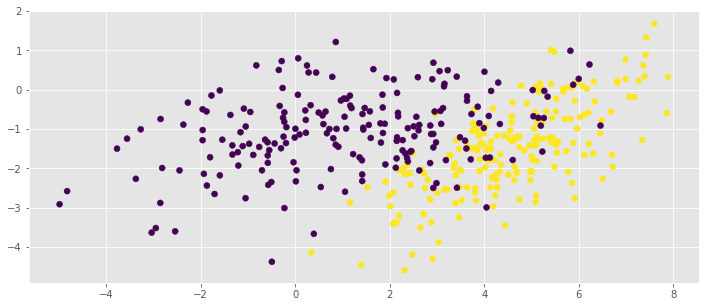

In [177]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 10337.52it/s]


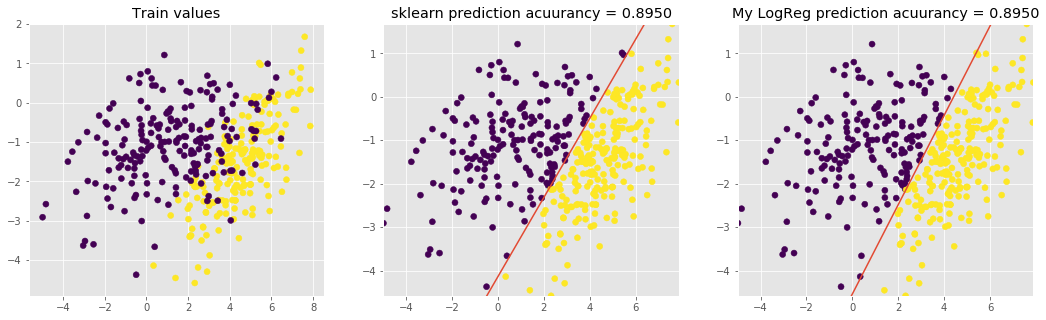

In [201]:
### Sklearn
fig, (ax0, ax1, ax2) = plt.subplots(1,3)
fig.set_size_inches(18,5)
ax1.set_xlim(min(X[:,0]), max(X[:,0]))
ax1.set_ylim(min(X[:,1]), max(X[:,1]))
ax2.set_xlim(min(X[:,0]), max(X[:,0]))
ax2.set_ylim(min(X[:,1]), max(X[:,1]))

t_x = np.array([x[:,0].min(), x[:,0].max()])


#Train
ax0.scatter(X[:,0],X[:,1], c = y)
ax0.set_title('Train values')

#Sklearn
model = LogisticRegression()
model.fit(X, y*2-1)

y_p = (model.predict(X)+1)/2
ax1.set_title("sklearn prediction acuurancy = %4.4f"%accuracy_score(y,y_p))
ax1.scatter(X[:,0],X[:,1], c = model.predict(X))

w = list(model.coef_[0])+[model.intercept_]
t_y = -(w[0]*t_x+w[-1])/w[1]
ax1.plot(t_x, t_y)

#Mine
x = X.copy()
model = LogReg(max_iter = 1000, C = 30, alpha = lambda i:1/np.log(2+i), tolerance=-1)
model.fit(x, y*2-1)
y_p = (model.predict(x)+1)/2
ax2.set_title('My LogReg prediction acuurancy = %4.4f'%accuracy_score(y,y_p))
ax2.scatter(x[:,0],x[:,1], c = y_p)

w = model.w
t_y = -(w[0]*t_x+w[-1])/w[1]
ax2.plot(t_x, t_y)

plt.show()

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [14]:
from sklearn.datasets import make_classification

In [15]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

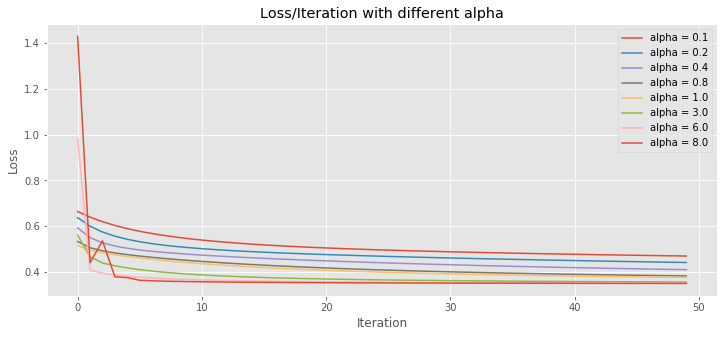

In [19]:
for alpha in [0.1, 0.2, 0.4, 0.8, 1.0, 3.0, 6.0, 8.0]:
    model = LogReg(max_iter=50, C = 8, alpha = alpha, tolerance=-1, verbose=False, gd_type = 'full')
    model.fit(X, y)
    plt.plot(model.loss_history, label = "alpha = "+str(alpha))
plt.title('Loss/Iteration with different alpha')
plt.xlabel('Iteration')
plt.ylabel("Loss")
plt.legend()
plt.show()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:141: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


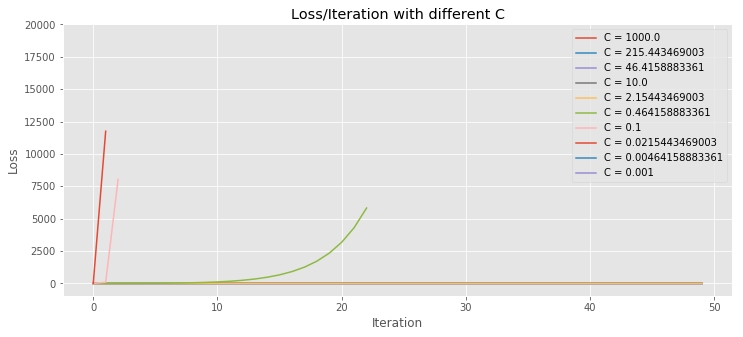

In [20]:
for C in np.logspace(3, -3, 10):
    model = LogReg(max_iter=50, C = C, alpha = 1.0, tolerance=-1, verbose=False)
    model.fit(X, y)
    plt.plot(model.loss_history, label = "C = "+str(C))
plt.title('Loss/Iteration with different C')
plt.xlabel('Iteration')
plt.ylabel("Loss")
plt.legend()
plt.show()

Для маленьких $С => 1/С >> 1$ и регуляризация перебивает $Loss$ - выходит решение при $w->0$

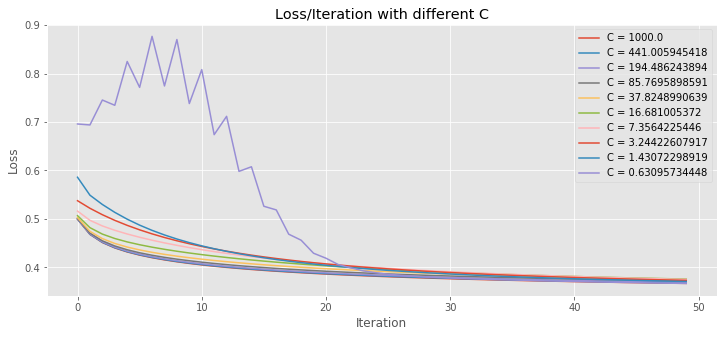

In [21]:
for C in np.logspace(3, -0.2, 10):
    model = LogReg(max_iter=50, C = C, alpha = 1.0, tolerance=-1, verbose=False)
    model.fit(X, y)
    plt.plot(model.loss_history, label = "C = "+str(C))
plt.title('Loss/Iteration with different C')
plt.xlabel('Iteration')
plt.ylabel("Loss")
plt.legend()
plt.show()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [22]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
# filepath = './trainingData_tabular_chunk1.csv'
# df_data = pd.read_csv(filepath, sep=',')

In [24]:
df_lst = []
for i in range(1,5):
    df_lst.append(pd.read_csv('lin_model_hw/trainingData_tabular/trainingData_tabular_chunk'+str(i)+'.csv'))

In [25]:
df = pd.concat(df_lst)

In [26]:
del df_lst

In [27]:
# для удобства
df.columns = df.columns.str.replace('.', '_')
df = df.set_index('gamestate_id')

In [30]:
df.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [31]:
# Распределение классов
df.decision.mean()

# Примерно поровну

0.50479949999999996

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


## Найдем категориальные признаки

In [418]:
df.describe()

,decision,turn,opponent_armor,opponent_attack,opponent_hero_card_id,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,...,player_played_hp_current,player_played_hp_max,player_hand_nOfMinions,player_hand_nOfSpells,player_hand_nOfWeapons,player_hand_nOfCards,player_hand_nOfPlayable,player_hand_attack,player_hand_crystals_cost,player_hand_hp
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,...,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,5.047995e-01,8.790442e+00,2.752520e-01,2.414955e-01,6.262082e+02,2.125768e+01,6.824150e-02,1.715745e-01,6.874061e+00,2.118114e+00,...,6.142033e+00,7.616494e+00,3.227028e+00,1.093025e+00,1.783090e-01,4.498362e+00,2.226971e+00,1.316197e+01,1.833761e+01,1.492705e+01
std,4.999771e-01,4.479720e+00,1.063647e+00,8.924247e-01,3.541551e+02,8.398885e+00,2.521599e-01,5.508937e-01,3.085446e+00,2.777065e+00,...,6.000602e+00,7.398553e+00,1.619559e+00,1.003658e+00,4.511275e-01,1.765792e+00,2.352390e+00,6.791000e+00,7.905209e+00,7.733505e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.500000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,3.900000e+02,1.500000e+01,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,...,1.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,8.000000e+00,1.300000e+01,9.000000e+00
50%,1.000000e+00,9.000000e+00,0.000000e+00,0.000000e+00,6.120000e+02,2.400000e+01,0.000000e+00,0.000000e+00,8.000000e+00,1.000000e+00,...,5.000000e+00,6.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,5.000000e+00,2.000000e+00,1.300000e+01,1.800000e+01,1.500000e+01
75%,1.000000e+00,1.200000e+01,0.000000e+00,0.000000e+00,7.980000e+02,2.900000e+01,0.000000e+00,0.000000e+00,1.000000e+01,3.000000e+00,...,1.000000e+01,1.200000e+01,4.000000e+00,2.000000e+00,0.000000e+00,6.000000e+00,4.000000e+00,1.800000e+01,2.400000e+01,2.000000e+01
max,1.000000e+00,3.100000e+01,2.100000e+01,7.000000e+00,1.235000e+03,3.000000e+01,1.000000e+00,4.000000e+00,1.000000e+01,1.000000e+01,...,4.600000e+01,5.500000e+01,1.000000e+01,8.000000e+00,4.000000e+00,1.000000e+01,1.000000e+01,5.000000e+01,5.600000e+01,5.500000e+01


In [45]:
y = df['decision'].get_values()
del df['decision']

In [42]:
key_count = {}
for key in df.keys():
    count = len(df[key].unique())
    print(key+'\t'+str(count))
    key_count[key] = count

turn	31
opponent_armor	22
opponent_attack	6
opponent_hero_card_id	9
opponent_hp	30
opponent_special_skill_used	2
opponent_weapon_durability	5
opponent_crystals_all	11
opponent_crystals_current	11
opponent_deck_count	27
opponent_fatigue_damage	8
opponent_hand_count	11
opponent_played_minions_count	8
player_armor	21
player_attack	8
player_hero_card_id	9
player_hp	30
player_special_skill_used	2
player_weapon_durability	5
player_crystals_all	10
player_crystals_current	11
player_deck_count	27
player_fatigue_damage	7
player_hand_count	11
player_played_minions_count	8
opponent_played_nOfCards	8
opponent_played_attack	50
opponent_played_crystals_cost	40
opponent_played_hp_current	46
opponent_played_hp_max	56
player_played_nOfCards	8
player_played_attack	60
player_played_crystals_cost	42
player_played_hp_current	47
player_played_hp_max	56
player_hand_nOfMinions	11
player_hand_nOfSpells	9
player_hand_nOfWeapons	5
player_hand_nOfCards	11
player_hand_nOfPlayable	11
player_hand_attack	50
player_han

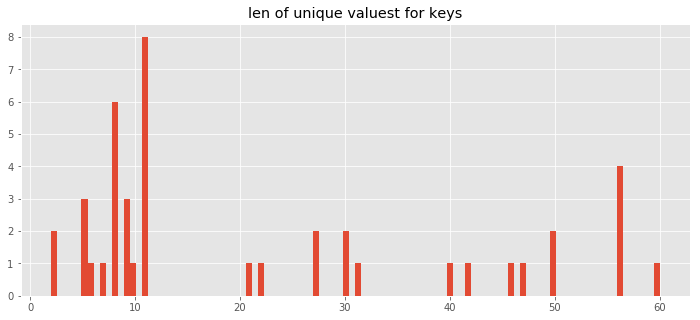

952


In [172]:
plt.title("len of unique valuest for keys")
plt.hist(key_count.values(), bins = 100)
plt.show()
print(sum(key_count.values()))

    Все признаки - категориальные
    На всем обучать просто нереально
    2E6 на 956 признаков - обучаться будет вечность
    
    Примем за категориальные признаки все <10 уникальных значений
    Остальные отнормируем x -> (x - min(x)) / (max(x) - min(x))

In [44]:
ONE_HOT = [i[0] for i in filter(lambda x:x[1]<10, key_count.items())]

In [48]:
df = pd.get_dummies(df, columns=ONE_HOT)

In [58]:
for key in df.keys():
    if len(df[key].unique()) >3:
        df[key] = (df[key] - df[key].min())/(df[key].max() - df[key].min())

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [61]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# make_pipeline(StandardScaler()) #Done this before

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [110]:
model = LogReg(gd_type='stochastic', C = 100, alpha=0.9, max_iter=300, batch_size=100000, tolerance = -1)
model.fit(df.get_values(), y*2-1)

100%|██████████| 300/300 [01:36<00:00,  3.45it/s]


LogReg(C=100,
    alpha=<function LogReg.__init__.<locals>.<lambda> at 0x1051d36a8>,
    batch_size=100000, gd_type='stochastic', max_iter=300, tolerance=-1,
    verbose=True, w0=None)

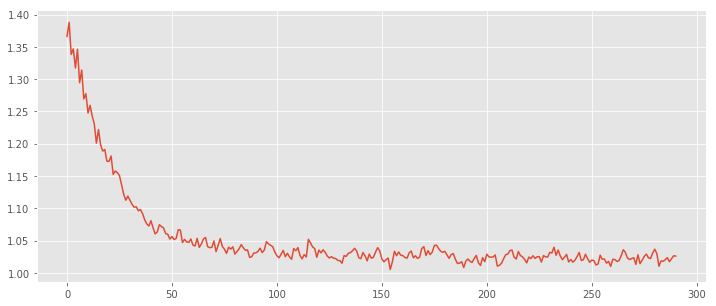

In [167]:
plt.plot(model.loss_history)

In [174]:
y_pred_train = model.predict_proba(df.get_values())

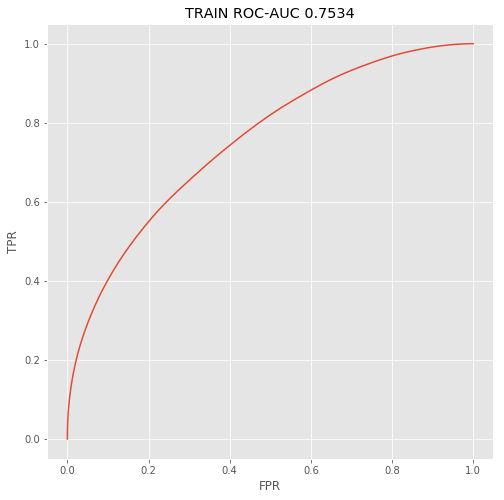

In [176]:
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure(figsize = (8,8))
temp = roc_curve(y*2-1, y_pred_train[:,1])
plt.title("TRAIN ROC-AUC %4.4f"%roc_auc_score(y*2-1, y_pred_train[:,1]))
FPR, TPR = temp[0], temp[1]
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(FPR, TPR)
plt.show()

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [147]:
df_lst = []
for i in range(5,8):
    df_lst.append(pd.read_csv('lin_model_hw/deprecated_testData_tabular/testData_tabular_chunk'+str(i)+'.csv'))
df_test = pd.concat(df_lst)
del df_lst
del df_test['decision']

In [154]:
y_test = pd.read_csv('lin_model_hw/deprecated_testLabels.txt', header = None)

In [155]:
df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')

In [156]:
df_test = pd.get_dummies(df_test, columns=ONE_HOT)

for key in df_test.keys():
    if len(df_test[key].unique()) >3:
        df_test[key] = (df_test[key] - df_test[key].min())/(df_test[key].max() - df_test[key].min())

In [162]:
y_test_pred = model.predict_proba(df_test.get_values())

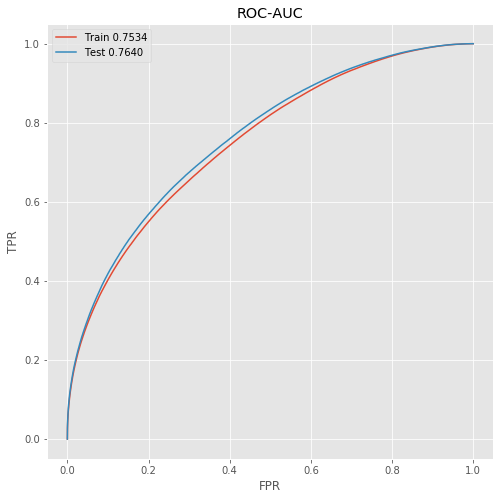

In [169]:
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure(figsize = (8,8))
plt.title("ROC-AUC")#%roc_auc_score(y*2-1, y_prob[:,1]))
temp = roc_curve(y*2-1, y_prob[:,1])
FPR, TPR = temp[0], temp[1]
plt.plot(FPR, TPR, label = "Train %4.4f"%roc_auc_score(y*2-1,    y_prob[:,1]))
temp = roc_curve(y_test*2-1, y_test_pred[:,1])
FPR, TPR = temp[0], temp[1]
plt.plot(FPR, TPR, label = "Test %4.4f" %roc_auc_score(y_test*2-1, y_test_pred[:,1]))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Странно, но на тесте ошибка немного меньше

##### В общем все красиво получилось